In [2]:
import sys

assert sys.version_info >= (3, 7)

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Training Models

So far we have treated ML models and their training algorithms mostly like black boxes. For the most part you dont need to know their implementation details.

However, having a good understanding of how things work can help you quickly pick the appropriate model, use the right training algorithm and a pick a good set of hyperparameters for your task. Understanding whats under the hood can also help you debug issues and perform error analysis. Lastly most of the topics discussed in this chapter will be essential in understanding, build and training neural networks (discussed in Part II of this book).


In this chapter we start off by looking at the linear regression model, one of the simplest models there is. We will discuss two very different way to train it:-
  - Using a 'closed' form equation that directly computes the model parameters that best fit the model to the training set (i.e. the model parameters that minimize the cost function over the training set)
  - Using an iterative approach called gradient descent (GD) that gradually tweaks the model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters as the first method. We will look at a few variants of gradient descent that we will again use when we study neural networks in Part II: batch GD, mini-batch GD, and stochastic GD.

Next we will look at polynomial regression, a more complex model that can fit non-linear datasets. Since this model has more parameters than linear regression, it is more prone to overfitting the training data. We will explore whether or not this is the case using learning curves, and then we will look at various regularization techniques that can reduce the risk of overfitting the training set.

Finally, we will examine two more models that are commonly used for classification tasks: logistic regression and softmax regression.

**Linear Regression**

In Chapter 1, we looked at a simple regression model of life satisfaction:

`life_satisfaction = theta_0 + theta_1 * GDP_per_capita`

This model is just a linear function of the input feature `GDP_per_capita` and `theta_0`, `theta_1` are the model's parameters.

More generally, a linear model makes a prediction by computing a weighted sum of its input features, plus a constant called a bias term (a.k.a. the intercept term)

`y_hat = theta_0 + theta_1 * x1 + theta_2 * x2 + ... + theta_n * xn`

In this equation:
  - y_hat is the predicted value
  - n is the number of input features
  - xi is the i'th model feature
  - theta_j is the jth model parameter
  
This can be written much more concisely using a vectorized form

`y_hat = h0(x) = 0 . x`

In this equation:
  - h0 is the hypothesis function, using the model parameters 0
  - 0 is the model's parameter vector, containing the bias term theta_0, and the feature weights theta_1 to theta_n
  - x is the instance's feature vector, containing x0 to xn, with x0 always equal to 1
  - 0 . x is the dot production of the vectors 0 and x, which is equal to `theta_0 + theta_1 * x1 + theta_2 * x2 + ... + theta_n * xn`

OK thats the linear regression model, but how do we train it? Recall that training a model means setting its parameters so that the model best fits the training set. For this, we measure how well (or how poorly) the model fits the training data. In Chapter 2, we saw that the most common performance measure of a regression training model is the RMSE (see Chapter 2 for equation)

Therefore to train a linear regression model, we need to find the value of 0 that minimizes the RMSE. In practice, its much easier to minimize the MSE than the RMSE and it leads to the same result.

**The Normal Equation**

The Normal Equation is an equation that gives a closed form solution to minimize the MSE.

$$\hat{\theta} = (X^TX)^{-1}X^Ty$$

In this equation:
  - $\hat{\theta}$ is the value of $\theta$ that minimizes the cost function
  - y is the vector of target values containing $y^1$ to $y^m$

In [5]:
# Let’s generate some linear-looking data to test this equation on
import numpy as np

np.random.seed(42) # to make this code example reproducible
m = 100 # number of instances
X = 2 * np.random.rand(m, 1) # column vector
y = 4 + 3 * X + np.random.randn(m, 1) # column vector

In [6]:
from sklearn.preprocessing import add_dummy_feature

# Now let’s compute 𝜃_hat using the Normal equation.
# We will use the inv() function from NumPy’s linear algebra module (np.linalg)
# to compute the inverse of a matrix, and
# the dot() method for matrix multiplication:

X_b = add_dummy_feature(X) # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
# the @ operator performs matrix multiplication, its equivalent to
# np.matmul(A, B) # if A and B are NumPy arrays
# many other libraries such as Tensorflow, PyTorch also support this operator

In [7]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [8]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

In [9]:
# Linear regression is based on np.linalg.lstsq() that returns the same result
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

**Computational Complexity**

The Normal equation computes the inverse of $X^TX$, which is an (n + 1) x (n + 1) matrix (where n is the number of features).

The complexity of inverting a mtrix is typically $O(n^2.4)$ to $O(n^3)$. If you double the number of features, you multiply the computation time roughly by $O(2^2.4)$ to $O(2^3)$, i.e. 5.3 to 8 times.

The SVD approach used by Linear Regression class is roughly $O(n^2)$.

So both the SVD and Normal equation get very slow as the number of features grows large. On the positive side, both a linear with regard to the number of instances in the training set, i.e. O(m). So both handle large training sets very efficiently, provided they fit in memory.

Now we look at a very different way to train a linear regression model, which is better suited for cases where there are a large number of features or too many instances to fit in memory.

**Gradient Descent**

Gradient descent is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of gradient descent is to tweak parameters iteratively in order to minimize a cost function.

In practice, you start by filling θ with random values (this is called random initialization). Then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function (e.g., the MSE), until the algorithm converges to a minimum.


An important parameter in gradient descent is the size of the steps, determined by the `learning rate` hyperparameter. If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time.

On the other hand, if the learning rate is too big, you might jump across the minimum and end up on the other side, possibly even higher than before. Tihs might make the algorithm diverge, with larger and larger values, failing to find a good solution.

Additionally, not all cost functions look like nice regular bowls, there maybe all sorts of irregular terrain, and local minima.

Fortunately, the MSE cost function for a linear regression model happens to be a convex function (which only have global minimum). 

While the cost function is a shape of a bowl, it can be a very elongated bowl if the features have very different scales. So when using gradient scale, you should ensure that all features have a similar scale (e.g. using the sklearn's `StandardScaler` class) or else it will take much longer to converge.

The diagram also illustrates that training a model means searching for a combination of model parameters that minimizes a cost function (over the training set).

It is a search in the model's `parameter space`. The more parameters a model has, the more dimensions this space has, and the harder the search is: searching for a needle in a 300-dimensional haystack is much trickier than searching in 3 dimensions.
Fortunately, since the cost function is convex in the case of linear regression, the needle is simply at the bottom of the bowl.

**Batch Gradient Descent**

To implement gradient descent, you need to compute the gradient of the cost function with regard to each model parameter θj.

In other words, you need to calculate how much the cost function will change if you change θj just a little bit. This is called a partial derivative. It is like asking, “What is the slope of the mountain under my feet if I face east”? and then asking the same question facing north (and so on for all other dimensions, if you can imagine a universe with more than three dimensions)

The gradient vecotr contains all the partial derivatives of the cost function

$$∇θMSE(θ) = 2/m * (X^T(X\theta - y))$$

In [10]:
eta = 0.1  # learning rate
n_epochs = 1000
m = len(X_b)  # number of instances

np.random.seed(42)
theta = np.random.randn(2, 1)  # randomly initialized model parameters

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

`gradients = 2 / m * X_b.T @ (X_b @ theta - y)`

Notice that this formula involves calculations over the full training set X, at each gradient descent step! This is why the algorithm is called batch gradient descent: it uses the whole batch of training data at every step (actually, full gradient descent would probably be a better name).

`theta = theta - eta * gradients`

Also notice, once you have the gradient vector, which points uphill, just go in the opposite direction to go downhill. This means subtracting ∇θMSE(θ) from θ. This is where the learning rate `eta` comes into play: multiply the gradient vector by `eta` to determine the size of the downhill step


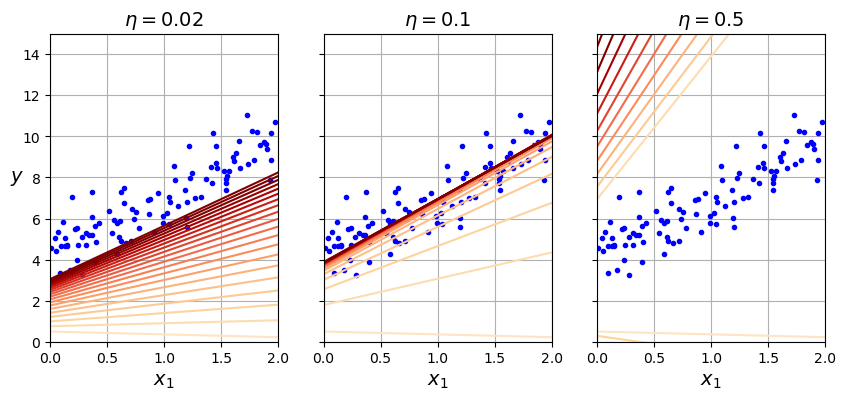

In [11]:
# extra code – generates and saves Figure 4–8

import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
plt.show()

On the left, the learning rate is too low: the algorithm will eventually reach the solution, but it will take a long time.

In the middle, the learning rate looks pretty good: in just a few epochs, it has already converged to the solution.

On the right, the learning rate is too high: the algorithm diverges, jumping all over the place and actually getting further and further away from the solution at every step.

To find a good learning rate, you can use grid search (see Chapter 2). However, you may want to limit the number of epochs so that grid search can eliminate models that take too long to converge.


You may wonder how to set the number of epochs. If it is too low, you will still be far away from the optimal solution when the algorithm stops; but if it is too high, you will waste time while the model parameters do not change anymore.

A simple solution is to set a very large number of epochs but to interrupt the algorithm when the gradient vector becomes tiny — that is, when its norm becomes smaller than a tiny number `ϵ` (called the tolerance) — because this happens when gradient descent has (almost) reached the minimum.

**Stochastic Gradient Descent**

The main problem with batch gradient descent is the fact that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large.

At the opposite extreme, stochastic gradient descent picks a random instance in the training set at every step and computes the gradients based only on that single instance.

This allows it to run faster and also makes it possible to train on huge training set since only one instance needs to be in memory at each iteration.

On the one hand, due to its stochastic nature, the algorithm is much less regular than batch GD, and the cost function will bounce up/down instead of gradually decreasing, and it will end up very close to the minimum but once it gets there it will continue to bounce around. So the final parameters will be good but not always optimal. But on other hand, since the cost function is irregular, this can actually help the algorithm jump out of local minima. So this algo has a better chance of finding the global minimum than batch gradient descent.

Therefore the algo is good for jumping out of local minima, but bad because it can never settle at the global minima. One solution to this is to gradually decrease the learning rate. The steps start out large (which helps make quick progress and escape local minima) and then smaller and smaller, allowing the algorithm to settle at the global minimum.

The function that determines the learning rate at each iteration is called the `learning schedule`.

In [12]:
theta_path_sgd = []  # extra code – we need to store the path of theta in the
                     #              parameter space to plot the next figure

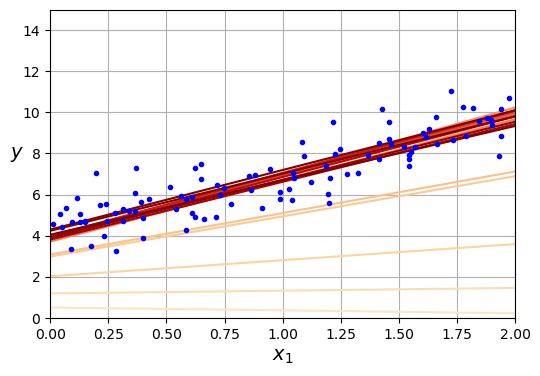

In [13]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

n_shown = 20  # extra code – just needed to generate the figure below
plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting

for epoch in range(n_epochs):
    # by convention we iterate by rounds of m iterations
    # each round is called an epoch
    # While batch GD iterated 1000 times through the whole training set
    # this code only iterated 50 times and reaches a pretty good solution
    for iteration in range(m):

        # extra code – these 4 lines are used to generate the figure
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  # extra code – to generate the figure

# extra code – this section beautifies and saves Figure 4–10
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

When using stochastic GD, the training instances must be independant and identically distributed so that the parameters get pulled towards the global optimum, on average.

One way to do this is to shuffle the instances during training (e.g. pick each instance randomly, or shuffle the training set at the beginning of each epoch.

If you do not shuffle the instances—for example, if the instances are sorted by label— then SGD will start by optimizing for one label, then the next, and so on, and it will not settle close to the global minimum.

In [14]:
from sklearn.linear_model import SGDRegressor

#To perform linear regression using stochastic GD with Scikit-Learn,
# you can use the SGDRegressor class, which defaults to optimizing
# the MSE cost function.

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel()) # y.ravel() because fit() expects 1D targets

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [15]:
# Once again, you find a solution quite close to
# the one returned by the Normal equation
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

**Mini-Batch Gradient Descent**

Mini-batch GD computes the gradients on small random sets of instances called mini-batches. The main advantage of mini-batch GD over stochastic GD is that you can get a performance boost from hardware optimization of matrix operations, especially when using GPUs. 

Its a good middle ground between batch and stochastic GD


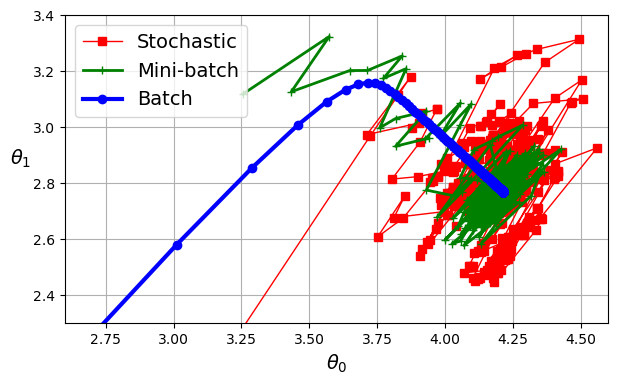

In [16]:
from math import ceil

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

t0, t1 = 200, 1000  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for iteration in range(0, n_batches_per_epoch):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]
        yi = y_shuffled[idx : idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1,
         label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2,
         label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3,
         label="Batch")
plt.legend(loc="upper left")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$   ", rotation=0)
plt.axis([2.6, 4.6, 2.3, 3.4])
plt.grid()
# save_fig("gradient_descent_paths_plot")
plt.show()

**Polynomial Regression**

What if your data is more complex than a straight line? We can use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called _polynomial regression_.

Let’s look at an example. First, we’ll generate some nonlinear data (see Figure 4-12), based on a simple quadratic equation — that’s an equation of the form y = ax² + bx + c — plus some noise:

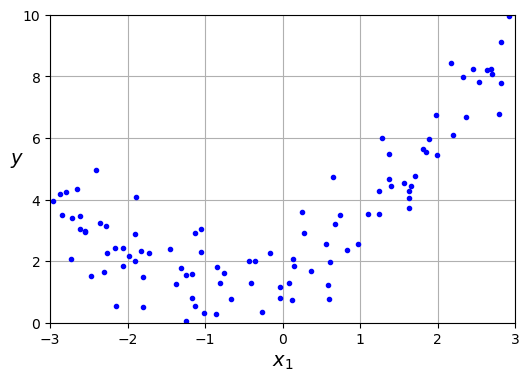

In [17]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

# extra code – this cell generates  Figure 4–12
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
# save_fig("quadratic_data_plot")
plt.show()

In [18]:
# lets use sklearns PolynomialFeatures class to transform our training data
# it will add the square (2nd degree polynomial) of each feature 
# in the training set as a new feature (in this case theres just one feature)
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

[-0.75275929]
[-0.75275929  0.56664654]


In [19]:
# X_poly now contains the original feature of X plus the square of this feature.
# Now we can fit a LinearRegression model to this extended training data

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

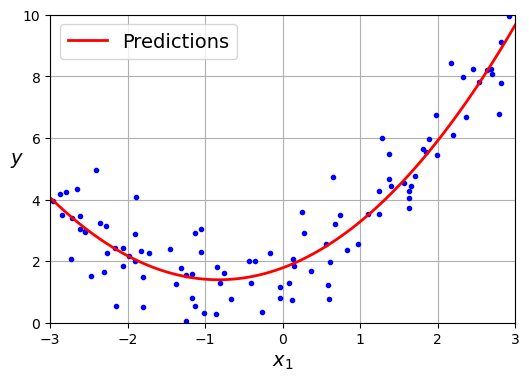

In [20]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
# save_fig("quadratic_predictions_plot")
plt.show()

Not bad: the model estimates $y = 0.56x_1^2 + 0.93x_1 + 1.78$ when in fact the original function was $y = 0.5x_1^2 + 1.0x_1 + 2.0 + Gaussian noise$

**Learning Curves**

If you perform high-degree polynomial regression, you will likely fit the training data much better than with plain linear regression. 

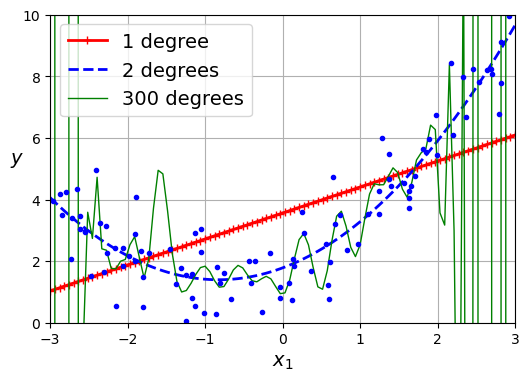

In [21]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6, 4))

for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
# save_fig("high_degree_polynomials_plot")
plt.show()

This high-degree polynomial regression model is severely overfitting the training data, while the linear model is underfitting it. The model that will generalize best in this case is the quadratic model, which makes sense because the data was generated using a quadratic model. 

But in general you won’t know what function generated the data, so how can you decide how complex your model should be? How can you tell that your model is overfitting or underfitting the data

In chapter 2, we used cross validation to get an estimate of the model's generalization performance.
  - If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, then the model is overfitting
  - If it performs poorly on both, then it is underfitting

Another way to tell is to look at `learning curves`.

`Learning curves` are plots of the model's training error and validation error as a function of the training iteration:
  - just evaluate the model at regular intervals on both the training set and the validation set, and plot the results. 
    - Note:- if the model cant be trained incrementally, (using `partial_fit()` or `warm_start`), then just train it several times on gradually larger subsets of the training set.
    - sklearn has a useful function `learning_curve()` that helps with above. By default it retrains the model on growing subsets of the training set. If the model supports incremental learning, you can set `exploit_incremental_learning=True` when calling learning_curve() and it will traing the model incrementally instead.

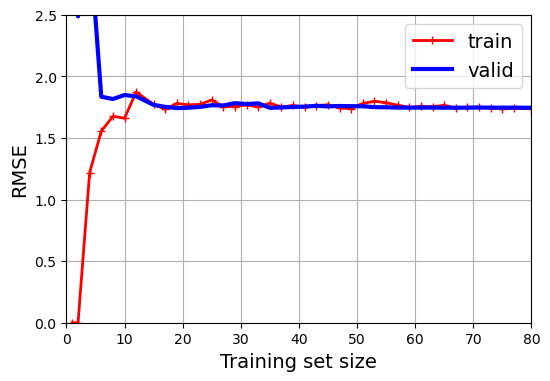

In [22]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
# save_fig("underfitting_learning_curves_plot")

plt.show()

The figure indicates that the model is under fitting.
  - the training error does not improve with more instances
  - the validation error is quite high (even with small training set size) and goes down very slowly with larger training set
  
These learning curves are typical of a model that’s underfitting. Both curves have reached a plateau; they are close and fairly high.

**If your model is underfitting the training data, adding more training examples will not help. You need to use a better model or come up with better features.**

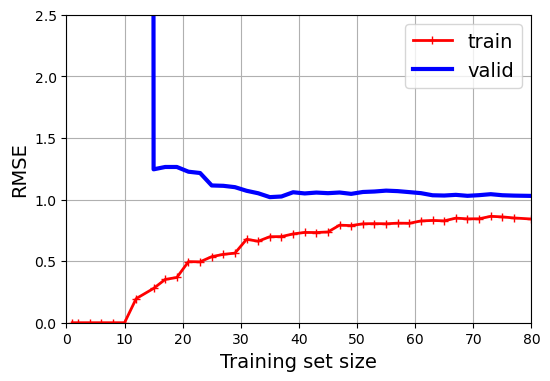

In [23]:
from sklearn.pipeline import make_pipeline

# Now lets look at the learning curve of the 10th degree polynomial model
# on the same data
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())
train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
# save_fig("underfitting_learning_curves_plot")

plt.show()

The curve has 2 important differences now
  - the training error is quite lower now
  - there is a gap between the training and validation error, meaning the model performed much better on the training set than the validation set
 
This is typical of a model thats overfitting.

One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.

**The Bias/Variance Trade-Off**

Bias:- this part of generalization error is due to wrong assumptions, e.g. assuming the data is linear when its actually quadratic, it makes the model prone to underfit the data

Variance:- this part is due to the model's excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have a high variance and thus overfit the training data.

Irreducible error:- This is due to the noisiness in the data itself. The only way to reduce this part of the error is to clearn up the data (e.g. remove outliers)

Increasing a model’s complexity will typically increase its variance and reduce its bias. 

Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a trade-off

**Regularized Linear Models**

As we saw in Chapters 1 and 2, a good way to reduce overfitting is to regularize the model (i.e. constraint it). A simple way to do so is to reduce the number of polynomial degrees.

This is typically done by constraining the weights of the model.
Lets look at ridge regression, lasso regression and elastic net regression that provide three ways to constrain the weights.

**Ridge Regression**

Adds a _regularization term_, $\alpha/m \sum^n_{i=1}\theta^2$, to the MSE cost function. This forces the learning algorithm to keep the weights as small as possible.

The new cost function is $J(\theta) = MSE(\theta) + \alpha/m \sum^n_{i=1}\theta^2$

Its important to scale the data (e.g. using `StandardScaler`), this is true for most regularized models so that they are not sensitive to the scale of the input features.

In [24]:
# lets generate a very small, noisy dataset

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

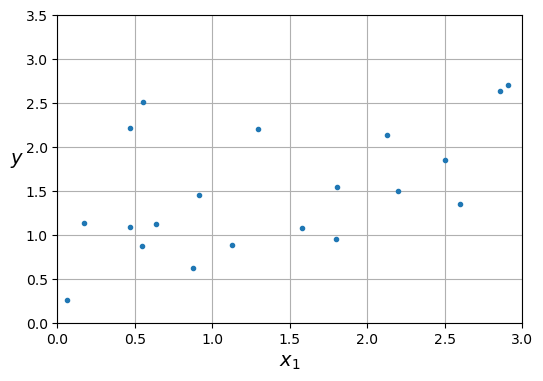

In [25]:
# extra code – a quick peek at the dataset we just generated
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

In [26]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

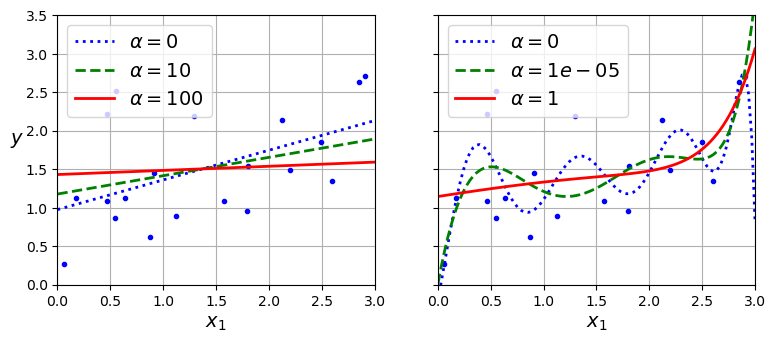

In [27]:

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
# save_fig("ridge_regression_plot")
plt.show()

On the left, plain ridge models are used, leading to linear predictions. On the right, the data is first expanded using `PolynomialFeatures(degree=10)` and then it is scaled using a `StandardScaler`, and then finally the ridge models are applied to the resulting features: this is polynomial regression with ridge regularization. Note how increasing the $\alpha$ leads to flatter predictions (thus reducing the variance but increasing the bias).

**Lasso Regression**

Least absolute shrinkage and selection operator regression. Its similar to ridge regression, it adds a regularization term to the cost function, but it uses the l1 norm of the weight vector instead of the square of the l2 norm.

An important characteristic of lasso regression is that it tends to eliminate the weights of the least important features (i.e. set them to 0).

In other words, lasso regression actually performs feature selection and outputs a _sparse model_ with few nonzero weights.



**Elastic Net Regression**

_Elastic Net Regression_ is a middle ground between ridge regression and lasso regression. The regularization term is a weighted sum of both ridge and lasso's regulization term, and you can control the mix ratio _r_.
  - when r = 0, its same as ridge regression
  - when r = 1, its same as lasso regression

So when should you use elastic net, ridge, lasso, or plain linear regression?

Regularization is useful, so generally you should avoid using plain linear regression. Ridge is a good default, but if you suspect only a few features are useful, you should prefer lasso or elastic net.

In general elastic net is preferred over lasso, because lasso may behave erratically when the number of features is greater than the number of training instances, or when several features are strongly correlated.

**Early Stopping**

A very different way to regularize the iterative learning algorithms such as GD is to stop training as soon as the validation error reaches a minimum. This is called _early stopping_.

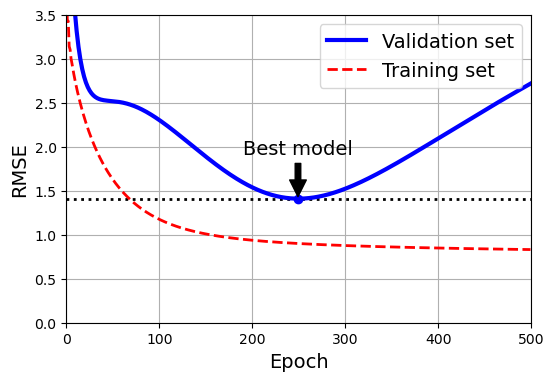

In [28]:
# Let's go back to the quadratic dataset we used earlier:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# extra code – creates the same quadratic dataset as earlier and splits it
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []  # extra code – it's for the figure below

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    # extra code – we evaluate the train error and save it for the figure
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)

# extra code – this section generates and saves Figure 4–20
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
# save_fig("early_stopping_plot")
plt.show()

As soon as the validation error starts going up, we stop, this indicates the model is starting to overfit the training data. This indicates we have reached a minimum. It is a simple and efficient regularization technique.

With stochastic and mini-batch gradient descent, the curves are not so smooth, and it may be hard to know whether you have reached the minimum or not. One solution is to stop only after the validation error has been above the minimum for some time (when you are confident that the model will not do any better), then roll back the model parameters to the point where the validation error
was at a minimum.)

**Logistic Regression**

some regression algorithms can be used for classification. Logistic regression is commonly used to estimate the probability that an instance belongs to a particular class (e.g. what is the probability that this email is spam?). 

If the estimated probability is greater than a given threshold (typically 50%), then the model predicts that the instance belongs to that class (called the _positive class_, labeled "1"). And vice versa, if its below the threshold it belongs to the _negative class_, labeled "0"

This makes it a binary classifier.

**Estimating Probabilities**

Just like a linear regression model, a logistic regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the linear regression model does, it outputs the `logistic` of this result.

$\hat{p} = h_{\theta}(x) = \sigma(\theta^Tx)$

the logistic - noted $\sigma(.)$ is a _sigmoid function_ (i.e. S-shaped) that outputs a number between 0 and 1.

$\sigma(t) = \dfrac{1}{1 + e^{-t}}$

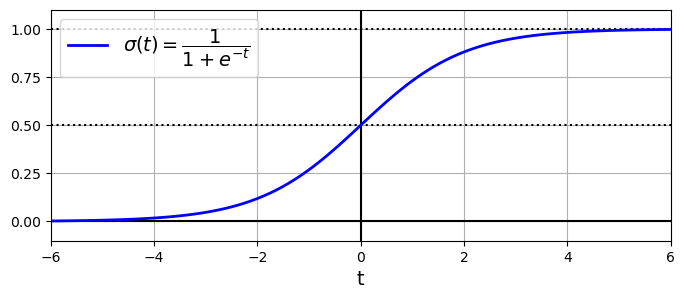

In [29]:
# extra code – generates and saves Figure 4–21

lim = 6
t = np.linspace(-lim, lim, 100)
sig = 1 / (1 + np.exp(-t))

plt.figure(figsize=(8, 3))
plt.plot([-lim, lim], [0, 0], "k-")
plt.plot([-lim, lim], [0.5, 0.5], "k:")
plt.plot([-lim, lim], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \dfrac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left")
plt.axis([-lim, lim, -0.1, 1.1])
plt.gca().set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.grid()
# save_fig("logistic_function_plot")
plt.show()

**Training and Cost function**

Now we know how a logistic regression model estimates probabilities and makes predictions, but how is it trained? The objective of the training is to set the parameter vector $\theta$, os that the model estimates high probabilities for positive instances (y = 1), and low probabilities for negative instances (y=0).

This idea is captured by the cost function shown in _Equation 4-16_ (TODO)

The bad news is that there is no known closed-form equation to compute the value of θ that minimizes this cost function (there is no equivalent of the Normal equation).

But the good news is that this cost function is convex, so gradient descent (or any other optimization algorithm) is guaranteed to find the global minimum (if the learning rate is not too large and you wait long enough).

(TODO) _Equation 4-18_

This equation looks very much like Equation 4-5: for each instance it computes the prediction error and multiplies it by the jth feature value, and then it computes the average over all training instances. Once you have the gradient vector containing all the partial derivatives, you can use it in the batch gradient descent algorithm.

That’s it: you now know how to train a logistic regression model. For stochastic GD you would take one instance at a time, and for mini-batch GD you would use a mini-batch at a time.

**Decision Boundaries**

We can use the iris dataset to illustrate logistic regression. This is a famous dataset that contains the sepal and petal length and width of 150 iris flowers of three different species: Iris setosa, Iris versicolor, and Iris virginica.

In [30]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [31]:
print(iris.DESCR)  # extra code – it's a bit too long

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [32]:
iris.target.head(3)  # note that the instances are not shuffled

0    0
1    0
2    0
Name: target, dtype: int32

In [33]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [36]:
# Next we’ll split the data and train a
# logistic regression model on the training set:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

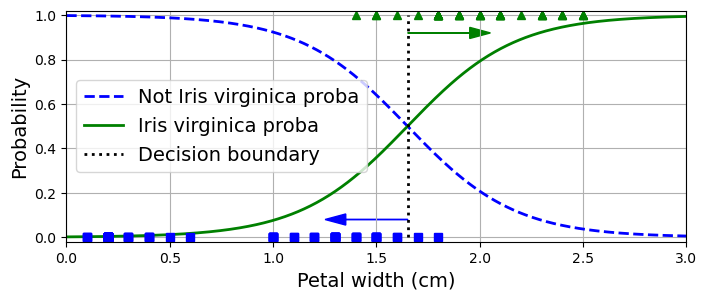

In [35]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)  # reshape to get a column vector
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.figure(figsize=(8, 3))  # extra code – not needed, just formatting
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")

# extra code – this section beautifies and saves Figure 4–23
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="g", ec="g")
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.axis([0, 3, -0.02, 1.02])
plt.grid()
# save_fig("logistic_regression_plot")

plt.show()

The petal width of Iris virginica flowers (represented as triangles) ranges from 1.4 cm to 2.5 cm, while the other iris flowers (represented by squares) generally have a smaller petal width, ranging from 0.1 cm to 1.8 cm. Notice that there is a bit of overlap.

Above about 2 cm the classifier is highly confident that the flower is an Iris virginica (it outputs a high probability for that class), while below 1 cm it is highly confident that it is not an Iris virginica (high probability for the “Not Iris virginica” class). In between these extremes, the classifier is unsure. 

However, if you ask it to predict the class (using the predict() method rather than the predict_proba() method), it will return whichever class is the most likely. Therefore, there is a decision boundary at around 1.6 cm where both probabilities are equal to 50%: if the petal width is greater than 1.6 cm the classifier will predict that the flower is an Iris virginica, and otherwise it will predict that it is not (even if it is not very confident):

In [37]:
decision_boundary

1.6516516516516517

In [38]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

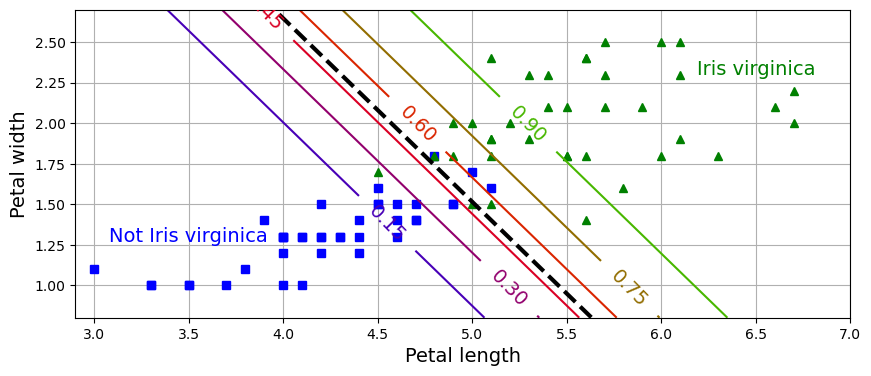

In [39]:
# extra code – this cell generates and saves Figure 4–24

X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

# for the contour plot
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]  # one instance per point on the figure
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# for the decision boundary
left_right = np.array([2.9, 7])
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])
             / log_reg.coef_[0, 1])

plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
# save_fig("logistic_regression_contour_plot")
plt.show()

Above figure shows the same dataset, but this time displaying two features: petal width and length. Once trained, the logistic regression classifier can, based on these two features, estimate the probability that a new flower is an Iris virginica. The dashed line represents the points where the model estimates a 50% probability: this is the model’s decision boundary. Note that it is a linear boundary.14 Each parallel line represents the points where the model outputs a specific probability, from 15% (bottom left) to 90% (top right). All the flowers beyond the top-right line have over 90% chance of being Iris virginica, according to the model

**Softmax Regression**

The logistic regression model can be generalized to support multiple classes directly, without having to train and combine multiple binary classifiers (as discussed in Chapter 3). This is called _softmax regression_ or _multinomial logistic regression_.

In [40]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# LogisticRegression classifier uses softmax regression automatically when
# you train it on more than two classes (assuming you use solver="lbfgs",
# which is the default)
softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

In [43]:
# So the next time you find an iris with petals that are 5 cm long and 2 cm wide
# , you can ask your model to tell you what type of iris it is,
# and it will answer Iris virginica (class 2) with 96% probability
# (or Iris versicolor with 4% probability):
softmax_reg.predict([[5, 2]])
# array([2])
softmax_reg.predict_proba([[5, 2]]).round(2)
# array([[0. , 0.04, 0.96]])

array([[0.  , 0.04, 0.96]])

In this chapter, we learned various ways to train linear models, both for regression and for classification

We used a closed-form equation to solve linear regression, as well as gradient descent, and we learned how various penalties can be added to the cost function during training to regularize the model.

Along the way, we also learned how to plot learning curves and analyze them, and how to implement early stopping.

Finally we learned how logistic regression and softmax regression work.

We've opened up the first machine learning black boxes! In the next chapter, we will open many more, starting with support vector machines.

**Exercises**

**1)  Which linear regression training algorithm can you use if you have a training set with millions of features?**

Mini-batch or Stochastic Gradient Descent

**2) Suppose the features in your training set have very different scales. Which algorithms might suffer from this, and how? What can you do about it?**

Mini-batch or Stochastic Gradient Descent, because the cost function might take longer to converge. To solve this we can use scale the data (StandardScaler).

**3) Can gradient descent get stuck in a local minimum when training a logistic
regression model?**

No, the cost function for logistic regression is convex

**4) Do all gradient descent algorithms lead to the same model, provided you let them run long enough?**

If the optimization problem is convex (such as Linear Regression or Logistic Regression), and assuming the learning rate is not too high, then all Gradient Descent algorithms will approach the global optimum and end up producing fairly similar models. However, unless you gradually reduce the learning rate, Stochastic GD and Mini-batch GD will never truly converge; instead, they will keep jumping back and forth around the global optimum. This means that even if you let them run for a very long time, these Gradient Descent algorithms will produce slightly different models.

**5) Suppose you use batch gradient descent and you plot the validation error at every epoch, if you notice that the validation error consistently goes up, what is like going on? How can you fix this?**

The learning rate is too high, and it seems that the algorithm missed the global minimum entirely, and the cost function is now diverging.
To fix this I would lower the learning rate

**6) Is it a good idea to stop mini-batch gradient descent immediately when the
validation error goes up?**

No because the algorithm is stochastic, so its not guaranteed that we've reached the minimum if we stop too early. A better solution is to save the model at regular intervals and roll back to the best model.

**7) Which gradient descent algorithm (among those we discussed) will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?**

Stochastic gradient descent will reach around the global minimum the fastest, however it will not converge. Batch GD will converge. To make stochastic or mini-batch GD converge, we can gradually lower the learning rate.

**8) Suppose you are using polynomial regression. You plot the learning curves and you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?**

if there is a large gap, and the training error is lower than the validation error, then the model is likely overfitting.
We can lower the degree of the model.
We can use regularization to solve this (lasso, ridge, elastic-net regression). Lastly we can also add more training data.

**9) Suppose you are using ridge regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter α or reduce it?**

The model likely suffers from underfitting, (high bias). We should reduce the regularization parameter to allow for more degrees of freedom.

**10) Why would you want to use:
a. Ridge regression instead of plain linear regression (i.e., without any
regularization)?
b. Lasso instead of ridge regression?
c. Elastic net instead of lasso regression?**

Regularization is generally used to reduce overfitting
a) Ridge regression is recommended to reduce overfitting
b) Lasso is recommended instead of ridge because it also tends to drop the least important features and it outputs a spare model. So we should use it when we suspect that only a few features are important
c) Elastic net is recommended over lasso, because lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

**11) Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime. Should you implement two logistic regression classifiers or one softmax regression classifier**

Since these are not exclusive classes (all four combinations are possible), we should implement two logistic regression classifiers.